# LangChain project

In this project, we will set up a basic LongChain model. For a similar entry prompt, we query multiple LLMs (t5, GPT2 and blenderbot) and use a metrics to pick the most revelant answer.

---


In [1]:
import os
os.environ['HUGGINGFACEHUB_API_TOKEN']=''

In [2]:
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, HuggingFaceHub, LLMChain
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, AutoModelForSeq2SeqLM

2023-06-01 16:38:01.889463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
template = """Question: {question}

Answer: Let's think step by step."""

prompt = PromptTemplate(template=template, input_variables=["question"])

# Models 

We will use the following models: google/flan-t5-base, gpt2-medium, facebook/blenderbot

In [4]:
model_id = 'google/flan-t5-base'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipe = pipeline(
    "text2text-generation",
    model=model, 
    tokenizer=tokenizer, 
    max_length=100
)

local_llm_t5 = HuggingFacePipeline(pipeline=pipe)

In [5]:
model_id = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    max_length=100
)

local_llm_gpt2 = HuggingFacePipeline(pipeline=pipe)

In [6]:
model_id = 'facebook/blenderbot-1B-distill'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipe = pipeline(
    "text2text-generation",
    model=model, 
    tokenizer=tokenizer, 
    max_length=100
)

local_llm_bld = HuggingFacePipeline(pipeline=pipe)

In [7]:
llm_chain_t5 = LLMChain(prompt=prompt, 
                     llm=local_llm_t5
                     )

question = "Who was the french president in 2000?"

rep_t5 = llm_chain_t5.run(question)

print(rep_t5)

The French president was Nicolas Sarkozy. Nicolas Sarkozy was the president of France from 2000 to 2001. The answer: Nicolas Sarkozy.


In [8]:
llm_chain_gpt2 = LLMChain(prompt=prompt, 
                     llm=local_llm_gpt2
                     )

rep_gpt2 = llm_chain_gpt2.run(question)

print(llm_chain_gpt2.run(question))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




The first president of this club of nations is still in office: President François Hollande, who succeeded the outgoing president Nicolas Sarkozy in office in 2015, who left office to become Prime Minister at the time and the current president of France, Emmanuel Macron of the centrist UMP party, who will be returning to the Élysée Palace in December for "a year of great commitment and leadership


In [9]:
llm_chain_bld = LLMChain(prompt=prompt, 
                     llm=local_llm_bld
                     )

rep_bld = llm_chain_bld.run(question)

print(rep_bld)

 I'm not sure who the French president was in 2000, but I do know that the current president is Donald J. Trump.


# Evaluation

We will use the following metric BERTScore

In [10]:
from evaluate import load

# Bertscore metrics :

bertscore = load("bertscore")


predictions = [rep_t5, rep_gpt2, rep_bld]
references = ["Jacques Chirac was the french president in 2000", "Jacques Chirac was the french president in 2000", "Jacques Chirac was the french president in 2000"]
results_bert = bertscore.compute(predictions=predictions, references=references, lang="en")

In [11]:
# Bleu metrics :

#t5 :
predictions_t5 = [rep_t5]
predictions_gpt2 = [rep_gpt2]
predictions_bld = [rep_bld]

references = ["Jacques Chirac was the french president in 2000"]
Bleu = load("bleu")
results_bleu = {"t5 " : Bleu.compute(predictions=predictions_t5, references=references), 
                "gpt2" : Bleu.compute(predictions=[rep_gpt2], references=references),
                "blenderbot" : Bleu.compute(predictions=[rep_bld], references=references)
                }

<AxesSubplot:>

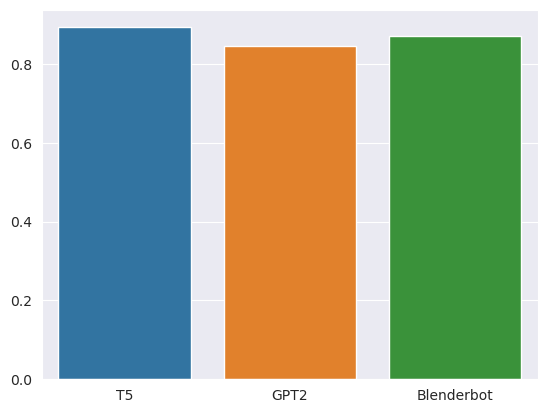

In [12]:
import seaborn as sns
sns.set_style("darkgrid")

sns.barplot(x=["T5", "GPT2", "Blenderbot"], y=[results_bert["f1"][0], results_bert["f1"][1], results_bert["f1"][2]])

For this question, t5 had the best f1 score. But the answer is not the best.

In [13]:
results_bert

{'precision': [0.8907017111778259, 0.8213495016098022, 0.8655298352241516],
 'recall': [0.8947720527648926, 0.8719547390937805, 0.8741407990455627],
 'f1': [0.8927322626113892, 0.8458959460258484, 0.8698140382766724],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.9(hug_trans=4.24.0)'}

In [14]:
results_bleu

{'t5 ': {'bleu': 0.0,
  'precisions': [0.16, 0.041666666666666664, 0.0, 0.0],
  'brevity_penalty': 1.0,
  'length_ratio': 3.125,
  'translation_length': 25,
  'reference_length': 8},
 'gpt2': {'bleu': 0.0,
  'precisions': [0.0547945205479452, 0.0, 0.0, 0.0],
  'brevity_penalty': 1.0,
  'length_ratio': 9.125,
  'translation_length': 73,
  'reference_length': 8},
 'blenderbot': {'bleu': 0.0,
  'precisions': [0.2, 0.041666666666666664, 0.0, 0.0],
  'brevity_penalty': 1.0,
  'length_ratio': 3.125,
  'translation_length': 25,
  'reference_length': 8}}